# Анализ поведения клиентов на примере сайта GB

**Задача:** провести анализ логов с сайта GB, рассчитать некоторые из метрик и выявить инсайты, которые могут быть полезны бизнесу.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, balanced_accuracy_score, \
                            confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.extmath import density
from sklearn.utils.class_weight import compute_sample_weight

from time import time

sns.set()
%matplotlib inline

**Данные:** логи сайта

In [2]:
fields_description = pd.read_excel('Описание полей.xlsx', sheet_name='Лист1')
fields_description

,Поле,Описание
0,session_id,идентификатор сессии
1,claim,признак наличия отправки формы заявки во вемя ...
2,60sec,признак длительности сессии 60 секунд и более ...
3,scroll_90,признак вертикальной прокрутки страницы глубин...
4,hit_date,дата сессии
5,referer_url,адрес реферера страницы просмотра
6,url,адрес страницы просмотра
7,utm_source,utm-метка источника
8,utm_medium,utm-метка канала
9,gender,"пол посетителя из куки (-1 – не определен, 0 –..."


# 1. Загрузка данных. Проверка корректности типов данных

In [3]:
gb_data = pd.read_csv("Датасет GB.csv")
gb_data.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,NaN,NaN,0,39,1,1,0
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,0,0
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,NaN,NaN,1,49,1,1,1
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,NaN,NaN,-1,-1,1,1,0
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,NaN,https://gb.ru/login,NaN,NaN,0,23,2,1,0


# 2. Исследовательский анализ данных

**Разведочный анализ данных** (exploratory data analysis, EDA) — предварительный анализ данных для определения общих закономерностей и свойств. Понятие введено математиком Джоном Тьюки.  
Цели анализа:  
* Максимальное «проникновение» в данные
* Выявление основных структур
* Выбор наиболее важных переменных
* Обнаружение отклонений и аномалий
* Проверка основных гипотез
* Разработка начальных моделей

In [4]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    884407 non-null  object
 1   claim         884407 non-null  int64 
 2   60sec         884407 non-null  int64 
 3   scroll_90     884407 non-null  int64 
 4   hit_date      884407 non-null  object
 5   referer_url   687598 non-null  object
 6   url           884407 non-null  object
 7   utm_source    245184 non-null  object
 8   utm_medium    244863 non-null  object
 9   gender        884407 non-null  int64 
 10  age           884407 non-null  int64 
 11  touch_screen  884407 non-null  int64 
 12  has_vk_id     884407 non-null  int64 
 13  has_ok_id     884407 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 94.5+ MB


In [5]:
# количество уникальных значений для каждого поля
for field in list(fields_description['Поле']):
    print(f"{field}: {len(gb_data[field].unique())}")

session_id: 864092
claim: 2
60sec: 2
scroll_90: 2
hit_date: 4
referer_url: 42581
url: 13477
utm_source: 184
utm_medium: 70
gender: 3
age: 121
touch_screen: 2
has_vk_id: 2
has_ok_id: 2


In [6]:
gb_data.describe()

,claim,60sec,scroll_90,gender,age,touch_screen,has_vk_id,has_ok_id
count,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000
mean,0.002071,0.313425,0.144197,-0.359456,14.844552,1.436307,0.449500,0.124044
std,0.045466,0.463886,0.351290,0.808853,21.505421,0.495927,0.497444,0.329631
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,29.000000,2.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,120.000000,2.000000,1.000000,1.000000


In [7]:
for field in ('claim', '60sec', 'scroll_90', 'gender', 'touch_screen', 'has_vk_id', 'has_ok_id', 'hit_date'):
    print(gb_data[field].value_counts())

0    882575
1      1832
Name: claim, dtype: int64
0    607212
1    277195
Name: 60sec, dtype: int64
0    756878
1    127529
Name: scroll_90, dtype: int64
-1    505397
 0    191518
 1    187492
Name: gender, dtype: int64
1    498534
2    385873
Name: touch_screen, dtype: int64
0    486866
1    397541
Name: has_vk_id, dtype: int64
0    774702
1    109705
Name: has_ok_id, dtype: int64
2021-12-02    250158
2021-12-01    227725
2021-12-04    211636
2021-12-03    194888
Name: hit_date, dtype: int64


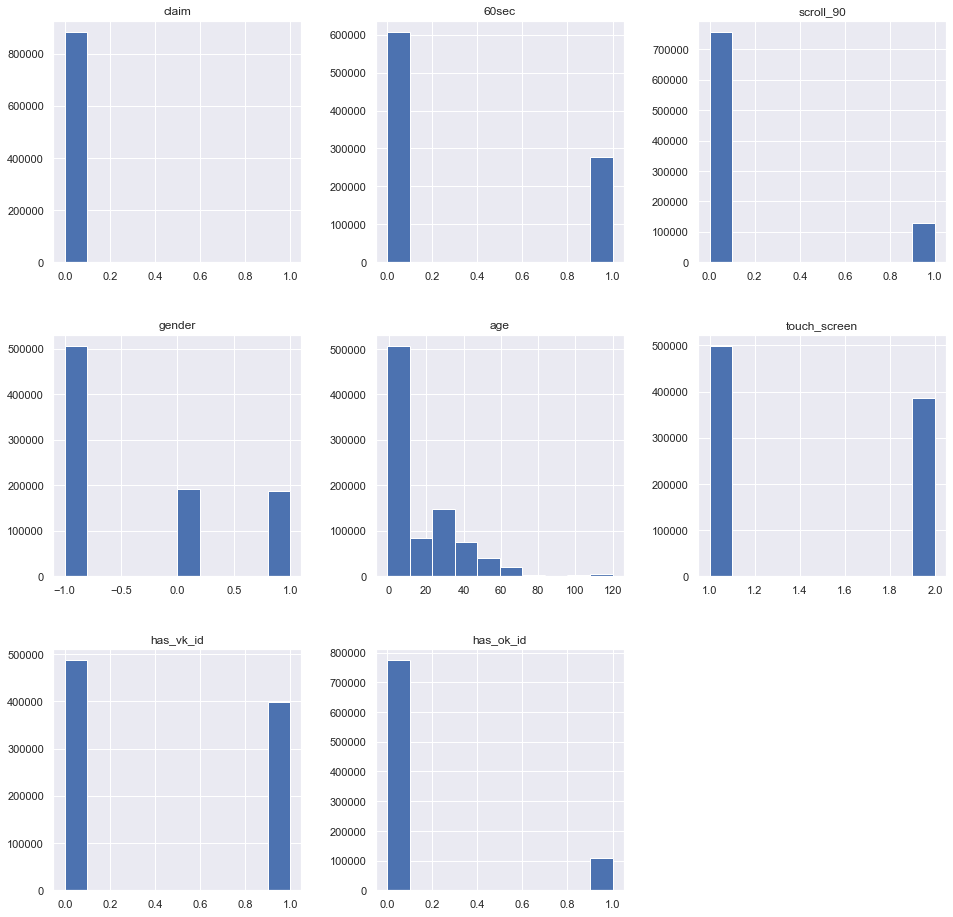

In [8]:
gb_data.hist(figsize=(16,16));

# 3. Статистический анализ данных

Статистический анализ данных:
* Анализ агрегированных характеристик (среднего значения, моды, медианы и так далее)
* Выявление аномалий с помощью статистических методов (например, IQR (метод межквартильных расстояний))
* Анализ типа распределения признаков
* Проверка гипотез (проведение статистических тестов)

In [9]:
# ...

# 4. Предобработка данных (обработка пропусков, аномалий)

In [10]:
bool_features = ['has_vk_id', 'has_ok_id', '60sec', 'scroll_90', 'claim']  # бинарные признаки
num_features = list(set(gb_data.select_dtypes(exclude='object').columns) - set(bool_features))  # числовые признаки
obj_features = list(gb_data.select_dtypes(include='object').columns)  # категориальные признаки
num_features, obj_features

(['gender', 'touch_screen', 'age'],
 ['session_id', 'hit_date', 'referer_url', 'url', 'utm_source', 'utm_medium'])

## Заполнение пропусков

In [11]:
cols_with_missing = [col for col in gb_data.columns if gb_data[col].isnull().any()]
for col in cols_with_missing:
    gb_data[col + '_undef'] = gb_data[col].isnull()
imputer = SimpleImputer(strategy="constant", fill_value="UNKNOWN")
columns = gb_data.columns.copy()
gb_data[obj_features] = pd.DataFrame(imputer.fit_transform(gb_data[obj_features]))
gb_data.columns = columns
# gb_data = gb_data.drop(cols_with_missing, axis=1)
gb_data.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,utm_medium_undef
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,UNKNOWN,UNKNOWN,0,39,1,1,0,False,True,True
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,0,0,False,False,False
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,UNKNOWN,UNKNOWN,1,49,1,1,1,False,True,True
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,UNKNOWN,UNKNOWN,-1,-1,1,1,0,False,True,True
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,UNKNOWN,https://gb.ru/login,UNKNOWN,UNKNOWN,0,23,2,1,0,True,True,True


## Преобразование категориальных признаков

In [12]:
# ordinal = OrdinalEncoder()
# gb_data[['utm_source', 'utm_medium']] = ordinal.fit_transform(gb_data[['utm_source', 'utm_medium']])
# gb_data.head()

In [13]:
gb_data[bool_features] = gb_data[bool_features].astype(bool)
gb_data['touch_screen'] = gb_data['touch_screen'].astype('uint8')

## Проектирование новых признаков

In [14]:
gb_data['gender_M'] = (gb_data['gender'] == 0).astype(bool)
gb_data['gender_F'] = (gb_data['gender'] == 1).astype(bool)
gb_data['gender_0'] = (gb_data['gender'] == -1).astype(bool)
gb_data.drop('gender', axis=1, inplace=True)

In [15]:
gb_data['age_child'] = ((0 <= gb_data['age']) & (gb_data['age'] < 13)).astype(bool)
gb_data['age_teen'] = ((13 <= gb_data['age']) & (gb_data['age'] < 20)).astype(bool)
gb_data['age_youth'] = ((20 <= gb_data['age']) & (gb_data['age'] < 35)).astype(bool)
gb_data['age_middle'] = ((35 <= gb_data['age']) & (gb_data['age'] < 60)).astype(bool)
gb_data['age_old'] = ((60 <= gb_data['age']) & (gb_data['age'] < 80)).astype(bool)
gb_data['age_antique'] = ((80 <= gb_data['age']) & (gb_data['age'] < 150)).astype(bool)
gb_data['age_unknown'] = (gb_data['age'] < 0).astype(bool)
# gb_data.drop('age', axis=1, inplace=True)

In [16]:
hit_date = pd.to_datetime(gb_data['hit_date'])
gb_data['hit_date'] = hit_date.dt.strftime("%Y-%m-%d (%a)")
# gb_data['weekday'] = gb_data['hit_date'].dt.day_name()  # день недели
gb_data['weekend'] = hit_date.dt.day_name().isin(['Saturday', 'Sunday']).astype(bool)  # выходной день

In [17]:
obj_val_cnts = {}
for key in ('referer_url', 'url', 'utm_source', 'utm_medium'):
    obj_val_cnts[key] = gb_data[key].value_counts().to_dict()

In [18]:
# urls = gb_data['referer_url'].copy()
# urls = urls.map(lambda x: '-' if "geekbrains" in x else x)
# len(urls.unique())

In [19]:
gb_data['referer_url'] = gb_data['referer_url'].map(lambda x:
                                                    'ONCE' if obj_val_cnts['referer_url'][x] == 1
                                                    else ('FEW' if obj_val_cnts['referer_url'][x] < 10 else x))
print(len(gb_data['referer_url'].unique()))
print(gb_data[~gb_data.fillna('UNKNOWN')['referer_url'].str.contains('|'.join(['gb.ru', 'geekbrains']))]['referer_url'].unique())

2219
['https://www.google.com/' 'UNKNOWN' 'ONCE'
 'https://m.ok.ru/app/1278486528' 'FEW' 'https://e.mail.ru/'
 'https://touch.mail.ru/' 'https://yandex.ru/' 'https://mail.google.com/'
 'https://mail.ru/' 'https://accounts.google.com/'
 'https://pulse.mail.ru/' 'https://away.vk.com/'
 'https://www.google.com.ua/' 'https://ok.ru/feed' 'https://touch.mail.ru'
 'https://www.google.ru' 'https://www.google.ru/' 'https://ad.mail.ru/'
 'https://www.facebook.com/' 'https://tutortop.ru/' 'https://yandex.ru'
 'https://ok.ru/game/candyvalley' 'https://yandex.ru/clck/jsredir'
 'https://puzzle-english.com/' 'https://cat.2035.university/'
 'https://news.mail.ru/' 'https://cloud.mail.ru' 'https://www.google.com'
 'https://www.yandex.ru/clck/jsredir' 'https://www.yandex.ru/'
 'https://horo.mail.ru/' 'https://touch.mail.ru/messages/'
 'https://paymentnew.ok.ru/dk' 'https://docviewer.yandex.ru/'
 'https://stvkr.com/' 'https://vse-kursy.com/' 'https://www.google.com.ua'
 'https://m.vk.com' 'https://kino.m

In [20]:
# urls = gb_data['url'].copy()
# urls = urls.map(lambda x: '-' if "gb.ru" in x else x)
# urls.unique()

In [21]:
gb_data['url'] = gb_data['url'].map(lambda x:
                                    'ONCE' if obj_val_cnts['url'][x] == 1 else ('FEW' if obj_val_cnts['url'][x] < 10 else x))
print(len(gb_data['url'].unique()))
print(gb_data[~gb_data.fillna('UNKNOWN')['url'].str.contains('|'.join(['gb.ru', 'geekbrains']))]['url'].unique())

1410
['https://project2850680.tilda.ws/' 'ONCE' 'FEW' 'file://'
 'https://project2850680.tilda.ws/test' 'https://gb-developer.webflow.io/'
 'http://gb-developer.webflow.io/' 'https://geek.ms/'
 'http://test-new-711174a3dcd82068cfefddc797c5b0.webflow.io/'
 'http://vebinary.webflow.io/' 'http://10.10.0.117:61184/register'
 'https://vebinary.webflow.io/kriticheskaya-massa'
 'https://a.a2.life/the_leader'
 'https://test-new-711174a3dcd82068cfefddc797c5b0.webflow.io/web-developer'
 'https://gb-developer.webflow.io/developer/programmer'
 'https://gb-developer.webflow.io/developer' 'https://a.a2.life/leader2'
 'https://a.a2.life/leader1'
 'https://webcache.googleusercontent.com/search'
 'https://vebinary.webflow.io/profportal'
 'http://project4809211.tilda.ws/live'
 'https://faculties.webflow.io/professiya-inzhener-po-testirovaniyu']


In [22]:
gb_data['utm_source'] = gb_data['utm_source'].map(lambda x: 'USELESS' if obj_val_cnts['utm_source'][x] < 100 else x)
gb_data['utm_source'].unique()

array(['UNKNOWN', 'google', 'sms', 'mt', 'yandex.ru', 'emarsys', 'aff',
       'tproger', 'mail.ru', 'sferum', 'flocktory', 'puzzle-english.com',
       'ya-zen', 'youtube.com', 'USELESS', 'vk.com', 'profidigital.ru',
       'message', 'yandex.zen', 'email', 'ig', 'yandex', 'portal',
       'proglib', 'telegram.org', 'youtube', 'instagram.com', 'admitad',
       'mytarget'], dtype=object)

In [23]:
gb_data['utm_medium'] = gb_data['utm_medium'].map(lambda x: 'USELESS' if obj_val_cnts['utm_medium'][x] < 100 else x)
gb_data['utm_medium'].unique()

array(['UNKNOWN', 'cpc', 'sms', 'email', 'cpa', 'commerce', 'partner',
       'chat', 'push_api', 'special_post', 'article', 'social', 'video',
       'USELESS', 'gr', 'site_more_details', 'admin', 'internal',
       'new_portal_navigation_under_search', 'special', 'workflow_push',
       'pr'], dtype=object)

In [24]:
gb_data.head(25)

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,age,...,gender_F,gender_0,age_child,age_teen,age_youth,age_middle,age_old,age_antique,age_unknown,weekend
0,4358a11f0d16be6e,False,False,True,2021-12-01 (Wed),https://gb.ru/education,https://gb.ru/comms/calendar,UNKNOWN,UNKNOWN,39,...,False,False,False,False,False,True,False,False,False,False
1,133509b7ff9a586c,False,False,False,2021-12-01 (Wed),https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,...,False,True,False,False,False,False,False,False,True,False
2,8b23cd36f2b08dcd,False,False,False,2021-12-01 (Wed),https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,UNKNOWN,UNKNOWN,49,...,True,False,False,False,False,True,False,False,False,False
3,50de4c060fd128f3,False,True,True,2021-12-01 (Wed),https://gb.ru/courses/1165,https://gb.ru/a/a1,UNKNOWN,UNKNOWN,-1,...,False,True,False,False,False,False,False,False,True,False
4,c2ca3cc9a67c749b,False,False,False,2021-12-01 (Wed),UNKNOWN,https://gb.ru/login,UNKNOWN,UNKNOWN,23,...,False,False,False,False,True,False,False,False,False,False
5,f8e5a48beec53c84,False,True,True,2021-12-01 (Wed),https://gb.ru/courses,https://gb.ru/courses/1161,UNKNOWN,UNKNOWN,68,...,True,False,False,False,False,False,True,False,False,False
6,d78d41d8657ce6e9,False,True,True,2021-12-01 (Wed),UNKNOWN,https://gb.ru/events/career-faq/long,sms,sms,-1,...,False,True,False,False,False,False,False,False,True,False
7,7e8f116543ae2ac3,False,False,False,2021-12-01 (Wed),ONCE,https://gb.ru/tests,UNKNOWN,UNKNOWN,46,...,True,False,False,False,False,True,False,False,False,False
8,6802ca836188146a,False,False,False,2021-12-01 (Wed),https://gb.ru/lessons/193691,https://gb.ru/tests/352,UNKNOWN,UNKNOWN,36,...,True,False,False,False,False,True,False,False,False,False
9,1ddc4439d8bbf8ed,False,False,False,2021-12-01 (Wed),https://gb.ru/courses/geek-school/,https://gb.ru/courses/geek-school/web,UNKNOWN,UNKNOWN,26,...,True,False,False,False,True,False,False,False,False,False


In [25]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   session_id         884407 non-null  object
 1   claim              884407 non-null  bool  
 2   60sec              884407 non-null  bool  
 3   scroll_90          884407 non-null  bool  
 4   hit_date           884407 non-null  object
 5   referer_url        884407 non-null  object
 6   url                884407 non-null  object
 7   utm_source         884407 non-null  object
 8   utm_medium         884407 non-null  object
 9   age                884407 non-null  int64 
 10  touch_screen       884407 non-null  uint8 
 11  has_vk_id          884407 non-null  bool  
 12  has_ok_id          884407 non-null  bool  
 13  referer_url_undef  884407 non-null  bool  
 14  utm_source_undef   884407 non-null  bool  
 15  utm_medium_undef   884407 non-null  bool  
 16  gender_M           8

In [26]:
# gb_data['url_len'] = gb_data['url'].str.len()
# # gb_data.drop('url', axis=1, inplace=True)

In [27]:
# gb_data[~gb_data.fillna('UNKNOWN')['referer_url'].str.contains('gb')]['referer_url'].unique()
# def utm_convert(value):
#     if value in ('google',):
#         return 'GOOGLE'
#     elif value in ('youtube.com', 'www.youtube.com'):
#         return 'YOUTUBE'
#     elif value in ('yandex.ru',):
#         return 'YANDEX'
#     elif value in ('yandex.ru',):
#         return 'YANDEX'
#     elif "lerna" in value:
#         return 'LERNA'
#     return value
# gb_data['utm_source'] = gb_data['utm_source'].map(utm_convert)
# gb_data['utm_source'].unique()

## Отбор признаков

In [28]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   session_id         884407 non-null  object
 1   claim              884407 non-null  bool  
 2   60sec              884407 non-null  bool  
 3   scroll_90          884407 non-null  bool  
 4   hit_date           884407 non-null  object
 5   referer_url        884407 non-null  object
 6   url                884407 non-null  object
 7   utm_source         884407 non-null  object
 8   utm_medium         884407 non-null  object
 9   age                884407 non-null  int64 
 10  touch_screen       884407 non-null  uint8 
 11  has_vk_id          884407 non-null  bool  
 12  has_ok_id          884407 non-null  bool  
 13  referer_url_undef  884407 non-null  bool  
 14  utm_source_undef   884407 non-null  bool  
 15  utm_medium_undef   884407 non-null  bool  
 16  gender_M           8

In [29]:
gb_data.drop(gb_data.select_dtypes(include='object').columns, axis=1, inplace=True)
gb_data.head()

,claim,60sec,scroll_90,age,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,utm_medium_undef,...,gender_F,gender_0,age_child,age_teen,age_youth,age_middle,age_old,age_antique,age_unknown,weekend
0,False,False,True,39,1,True,False,False,True,True,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,-1,2,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,False,False,False,49,1,True,True,False,True,True,...,True,False,False,False,False,True,False,False,False,False
3,False,True,True,-1,1,True,False,False,True,True,...,False,True,False,False,False,False,False,False,True,False
4,False,False,False,23,2,True,False,True,True,True,...,False,False,False,False,True,False,False,False,False,False


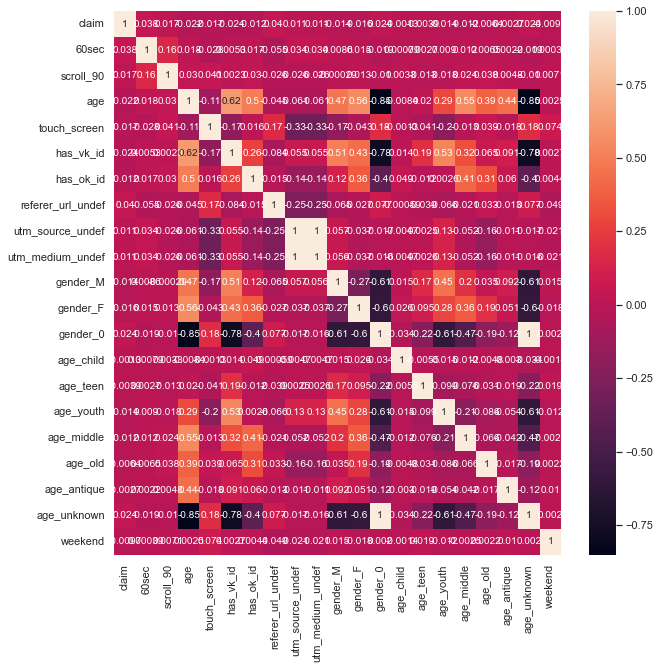

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(gb_data.corr(), annot=True);

# 5. Построение воронки клиентов

Воронка продаж — это аналитический инструмент, который позволяет понять, как ваш потенциальный клиент приходит к решению о покупке ваших товаров или услуг.  
В рамках проекта нужно:
* Провести обработку поля 'referer_url’ и выделить категории (посещение урока, поиск, вход в личный кабинет и так далее).
* Определить, какие события будут показателями того, что клиент доволен сервисом.
* Сформулировать выводы по проведённому анализу.

In [31]:
# ...

# 6. Выявление инсайтов в данных

На какие вопросы ищем ответы:
* Какие действия клиенты GB совершают чаще всего?
* Есть ли аномалии в поведении пользователей: например, большое число коротких (менее 60 с.) сессий? С чем эти аномалии могут быть связаны?
* На каких страницах прокрутка 90% и более?
* В какие даты было больше всего сессий? Рассчитайте DAU, MAU, WAU (*среднестатистическое число уникальных пользователей за день, за неделю и за месяц соответственно*).
* Какие изменения на сайте могут улучшить показатели: число посещений, длительность сессии и другие?

In [32]:
# ...

In [33]:
# claim_0_rate = sum(gb_data['claim'] == 0) / len(gb_data)
# claim_1_rate = sum(gb_data['claim'] == 1) / len(gb_data)
# print(claim_0_rate, claim_1_rate)

In [34]:
# TARGET = 'claim'
# X = gb_data.drop(TARGET, axis=1)
# y = gb_data[TARGET]

In [35]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [36]:
# mod_cols = ['touch_screen']  # 'url_len'
# scaler = MinMaxScaler().fit(X_train[mod_cols])
# X_train[mod_cols] = scaler.transform(X_train[mod_cols])
# X_test[mod_cols] = scaler.transform(X_test[mod_cols])

In [37]:
# pd.DataFrame(data=X_train, columns=X.select_dtypes(exclude='object').columns).describe()

In [38]:
# # model = LogisticRegression(random_state=42, class_weight='balanced')
# # model = LinearSVC(random_state=42, class_weight='balanced')
# model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# # model = ComplementNB()
# # model = SVC(random_state=42, max_iter=2000, gamma='auto', class_weight='balanced')
# # model = SGDClassifier()

# # model = xgb.XGBClassifier(random_state=42)
# # model = lgbm.LGBMClassifier(random_state=42, class_weight='balanced')
# # model = catb.CatBoostClassifier(silent=True, random_state=42, auto_class_weights='Balanced')

# sample_weights = None  # compute_sample_weight(class_weight='balanced', y=y_train)
# model.fit(X_train, y_train, sample_weight=sample_weights)